In [1]:
###### load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import binarize
import pickle
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize
# from mapseq_fxns import sort_by_celltype
# from math import log10
from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests

# for custom colormaps
from matplotlib import cm 
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

# random sample consistent between runs
import random

# import multiple t-tests
from statsmodels.sandbox.stats.multicomp import multipletests

%matplotlib inline

In [10]:
in_path = '/Volumes/Data/Emily/MAPseq/combined_analysis_M194_M220/processed_data/'
out_path = '/Volumes/Data/Emily/MAPseq/combined_analysis_M194_M220/output/'

num_samples = 12
mice = ["MMM1","MMF2", "MMF3", "STM1", "STM2", "STF3", 'MMM4', 'MMF5', 'STF4', 'STM5', 'STF6', 'STM7']
species = ["Mmus"]*3 + ["Steg"]*3 + ["Mmus"]*2 + ["Steg"]*4
sex = ["male", "female", "female", "male", "male", "female", "male", "female", "female", "male", "female", "male"]
dataset = ['M194']*6 + ['M220']*6
colors = {'M194':'blue', 'M220':'orange'}
metadata = pd.DataFrame({'mice':mice, "species":species, "sex":sex, "dataset":dataset})

random.seed(10)

In [11]:
#### load data

with open(in_path +'M194_M220_ACA_bin4.pkl', 'rb') as f:
    aca_bin = pickle.load(f)

In [12]:
# create custum colormaps
# green = OMC
# purple = ACA
# blue = lab mo
# create purple colormap
N = 256
purple = np.ones((N, 4))
purple[:, 0] = np.linspace(1, 146/256, N) # R = 146
purple[:, 1] = np.linspace(1, 39/256, N) # G = 39
purple[:, 2] = np.linspace(1, 143/256, N)  # B = 143
purple_cmp = ListedColormap(purple)

green = np.ones((N, 4))
green[:, 0] = np.linspace(1, 5/256, N) # R = 5
green[:, 1] = np.linspace(1, 104/256, N) # G = 104
green[:, 2] = np.linspace(1, 57/256, N)  # B = 57
green_cmp = ListedColormap(green)

orange = np.ones((N, 4))
orange[:, 0] = np.linspace(1, 242/256, N) # R = 242
orange[:, 1] = np.linspace(1, 101/256, N) # G = 101
orange[:, 2] = np.linspace(1, 34/256, N)  # B = 34
orange_cmp = ListedColormap(orange)

blue = np.ones((N, 4))
blue[:, 0] = np.linspace(1, 33/256, N) # R = 33
blue[:, 1] = np.linspace(1, 64/256, N) # G = 64
blue[:, 2] = np.linspace(1, 154/256, N)  # B = 154
blue_cmp = ListedColormap(blue)

In [13]:
# sort by cell type function??? doesn't work when imported???

def sort_by_celltype(proj, it_areas=["ACAc", "AUD", "STR"], ct_areas=["TH"], pt_areas=["AMY","SNr","SCm","PG","PAG","RN"]):
    """
    Function takes in projection matrix and outputs matrix sorted by the 3 major celltypes:
    - IT = intratelencephalic (projects to cortical and/or Striatum), type = 10
    - CT = corticalthalamic (projects to thalamus w/o projection to brainstem), type = 100
    - PT = pyramidal tract (projects to brainstem += other areas), type = 1000
    Returns single dataframe with cells sorted and labelled by 3 cell types (IT/CT/PT)
    
    default areas:
    - it_areas=["OMCc", "AUD", "STR"]
    - ct_areas=["TH"]
    - pt_areas=["AMY","SNr","SCm","PG","PAG","RN"]
    """
    
    ds=proj
    
    # 1. isolate PT cells
    pt_counts = ds[pt_areas].sum(axis=1)
    pt_idx = ds[pt_counts>0].index
    ds_pt = ds.loc[pt_idx,:]
    ds_pt = ds_pt.sort_values(['PAG','AMY'], ascending=False)
    ds_pt['type'] = 1000

    # Isolate remaining non-PT cells
    ds_npt = ds.drop(pt_idx)
    ds_npt.reset_index(drop=True)

    # Identify CT cells by thalamus projection # THIS USED TO WORK, NOW IT DOESN'T???
    #     th_idx = ds_npt[ct_areas] > 0
    #     ds_th = ds_npt[th_idx]
    #     th_TF = ds_npt[ct_areas] > 0
    #     th_idx = th_TF.index
    #     ds_th = ds_npt.loc[th_index, :]
    ds_th = ds_npt[ds_npt.TH > 0]

    ds_th = ds_th.sort_values('TH', ascending=False)
    ds_th['type'] = 100

    #     # Identify IT cells by the remaining cells (non-PT, non-CT)
    ds_nth = ds_npt[~(ds_npt.TH > 0)]
    ds_nth = ds_nth.sort_values(it_areas,ascending=False)
    ds_nth['type'] = 10

    # combine IT and CT cells
    ds_npt = pd.concat([ds_nth, ds_th], ignore_index=True)

    # combine IT/CT and PT cells
    sorted_ds = pd.concat([ds_npt,ds_pt],ignore_index=True)

    sorted_ds=sorted_ds.reset_index(drop=True)

    return sorted_ds

In [14]:
# seperate by cell type

aca_type = [sort_by_celltype(aca_bin[i]) for i in range(num_samples)]
aca_pt = [(aca_type[i][aca_type[i]['type']==1000]).drop(["type"], axis=1).reset_index(drop=True) for i in range(num_samples)]
aca_it = [(aca_type[i][aca_type[i]['type']==10]).drop(["type"], axis=1).reset_index(drop=True) for i in range(num_samples)]

mm_i = [0,1,2,6,7]
st_i = [3,4,5,8,9,10,11]

aca_mm = []
aca_st = []
aca_pt_mm = []
aca_pt_st = []
aca_it_mm = []
aca_it_st = []
mice_mm=[]
mice_st=[]

for i in range(num_samples):
    if i in mm_i:
        aca_mm.append(aca_type[i])
        aca_pt_mm.append(aca_pt[i])
        aca_it_mm.append(aca_it[i])
        mice_mm.append(mice[i])
    else:
        aca_st.append(aca_type[i])
        aca_pt_st.append(aca_pt[i])
        aca_it_st.append(aca_it[i])
        mice_st.append(mice[i])

aca_mm_all = pd.concat(aca_mm)
aca_st_all = pd.concat(aca_st)

In [15]:
# clean-up datasets
# drop OB, ACAc, HIP
to_drop = ['OB', 'OMCi', 'OMCc', 'HIP']
aca_mm_all = aca_mm_all.drop(to_drop, axis=1)
aca_st_all = aca_st_all.drop(to_drop, axis=1)

# change RN to BS
aca_mm_all = aca_mm_all.rename(columns={'RN':'BS'})
aca_st_all = aca_st_all.rename(columns={'RN':'BS'})


# change type so .25,.5,.75
mm_type_col = aca_mm_all['type']
mm_replace = np.where(mm_type_col==1000, 0.75, mm_type_col)
mm_replace = np.where(mm_replace==100, 0.5, mm_replace)
mm_replace = np.where(mm_replace==10, 0.25, mm_replace)
aca_mm_all['type'] = mm_replace

# change type so .25,.5,.75
st_type_col = aca_st_all['type']
st_replace = np.where(st_type_col==1000, 0.75, st_type_col)
st_replace = np.where(st_replace==100, 0.5, st_replace)
st_replace = np.where(st_replace==10, 0.25, st_replace)
aca_st_all['type'] = st_replace

print(aca_mm_all.shape)
print(aca_st_all.shape)
aca_mm_all.columns

(117113, 13)
(14725, 13)


Index(['ACAi', 'ACAc', 'AUD', 'STR', 'TH', 'HY', 'AMY', 'SNr', 'SCm', 'PG',
       'PAG', 'BS', 'type'],
      dtype='object')

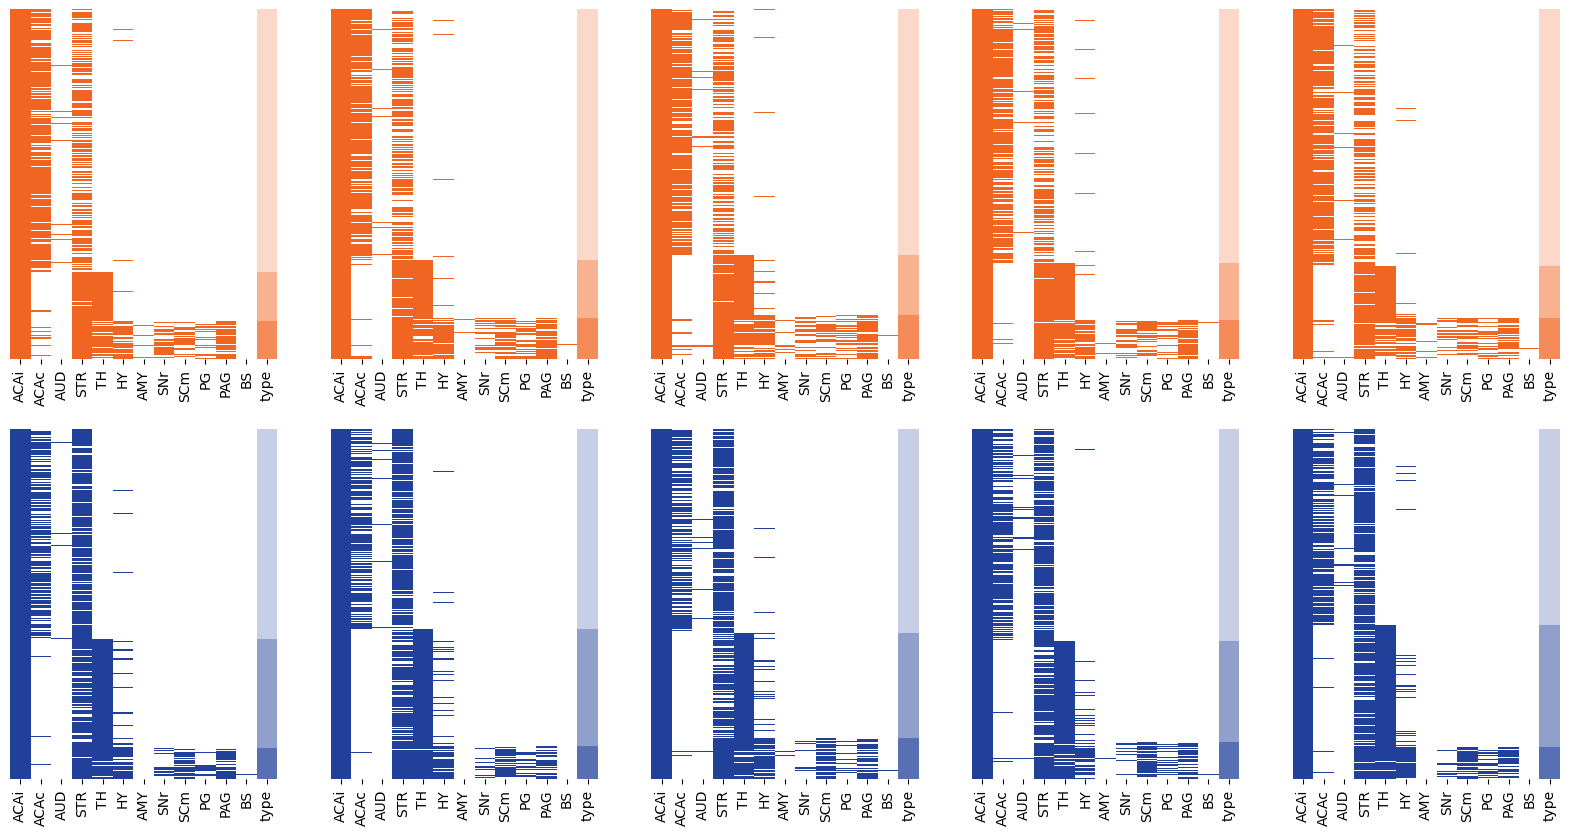

In [16]:
# randomly sample 1000 neurons and display as heatmap
fig, axs = plt.subplots(2,5, figsize=(20,10))

for ax in axs.flat[:5]:

    plot = aca_st_all.sample(1000)
    # sort by cell type
    plot = plot.sort_values(by=['type']).reset_index(drop=True)
    
    sns.heatmap(plot, cmap=orange_cmp, cbar=False, ax=ax)
    ax.get_yaxis().set_visible(False)


# randomly sample 1000 neurons and display as heatmap
# fig, axs = plt.subplots(1,5, figsize=(20,5))

for ax in axs.flat[5:]:

    plot = aca_mm_all.sample(1000)
    # sort by cell type
    plot = plot.sort_values(by=['type']).reset_index(drop=True)
    
    sns.heatmap(plot, cmap=blue_cmp, cbar=False, ax=ax)
    ax.get_yaxis().set_visible(False)

# fig.savefig(out_path+"mm_st_multiple_1000_heatmaps.jpeg", dpi=300)

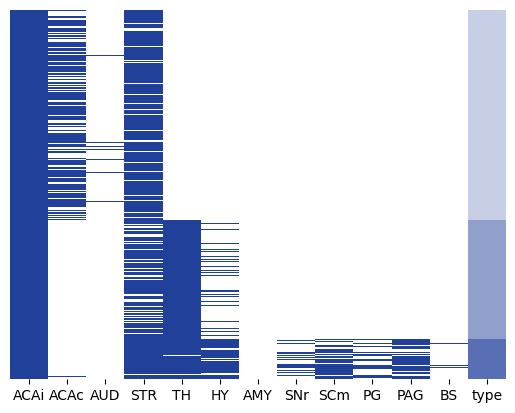

In [17]:
plot = aca_mm_all.sample(1000)
# sort by cell type
plot = plot.sort_values(by=['type']).reset_index(drop=True)

sns.heatmap(plot, cmap=blue_cmp, cbar=False)
plt.gca().get_yaxis().set_visible(False)
# plt.savefig(out_path+"mm_single_heatmap.jpeg", dpi=300)

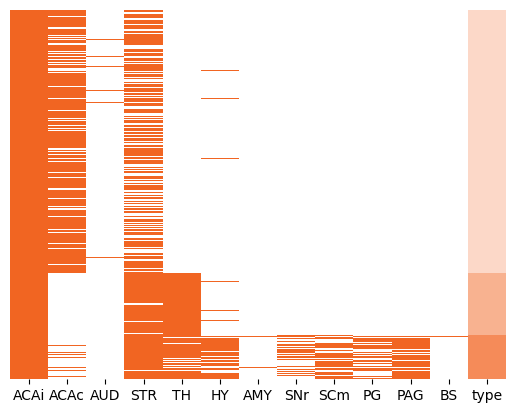

In [18]:
plot = aca_st_all.sample(1000)
# sort by cell type
plot = plot.sort_values(by=['type']).reset_index(drop=True)

sns.heatmap(plot, cmap=orange_cmp, cbar=False)
plt.gca().get_yaxis().set_visible(False)
# plt.savefig(out_path+"st_single_heatmap.jpeg", dpi=300)

# heatmaps of an individual animal

In [19]:
for i in range(len(aca_st)):
    print(aca_st[i].shape)

(647, 17)
(4827, 17)
(2544, 17)
(707, 17)
(1956, 17)
(2571, 17)
(1473, 17)


In [20]:
# clean-up datasets
# drop OB, ACAc, HIP
to_drop = ['OB', 'ACAi', 'ACAc', 'HIP']
for i in range(len(aca_mm)):
    aca_mm[i] = aca_mm[i].drop(to_drop, axis=1)
    # change RN to BS
    aca_mm[i] = aca_mm[i].rename(columns={'RN':'BS'})
    # change type so .25,.5,.75
    mm_type_col = aca_mm[i]['type']
    mm_replace = np.where(mm_type_col==1000, 0.75, mm_type_col)
    mm_replace = np.where(mm_replace==100, 0.5, mm_replace)
    mm_replace = np.where(mm_replace==10, 0.25, mm_replace)
    aca_mm[i]['type'] = mm_replace

for i in range(len(aca_st)):
    aca_st[i] = aca_st[i].drop(to_drop, axis=1)
    aca_st[i] = aca_st[i].rename(columns={'RN':'BS'})
    # change type so .25,.5,.75
    st_type_col = aca_st[i]['type']
    st_replace = np.where(st_type_col==1000, 0.75, st_type_col)
    st_replace = np.where(st_replace==100, 0.5, st_replace)
    st_replace = np.where(st_replace==10, 0.25, st_replace)
    aca_st[i]['type'] = st_replace






print(aca_mm[1].shape)
print(aca_st[2].shape)
aca_mm[0].columns

(31033, 13)
(2544, 13)


Index(['OMCi', 'OMCc', 'AUD', 'STR', 'TH', 'HY', 'AMY', 'SNr', 'SCm', 'PG',
       'PAG', 'BS', 'type'],
      dtype='object')

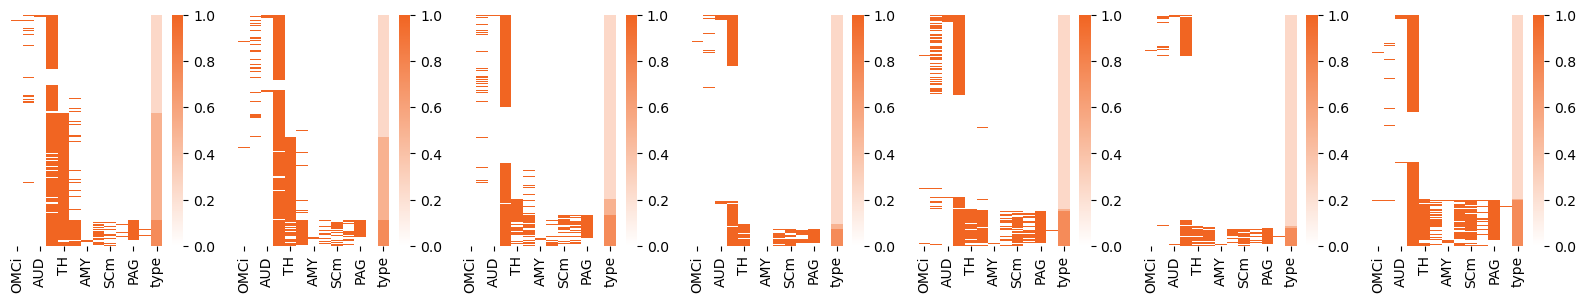

In [21]:
fig, axs = plt.subplots(1, len(aca_st), figsize=(20,3))

i=0
for ax in axs.flat:
    sns.heatmap(aca_st[i], cmap=orange_cmp, ax=ax)
    ax.get_yaxis().set_visible(False)
    i+=1
    
# fig.savefig(out_path+"aca_st_N1_heatmaps.jpeg", dpi=300, bbox_inches="tight")

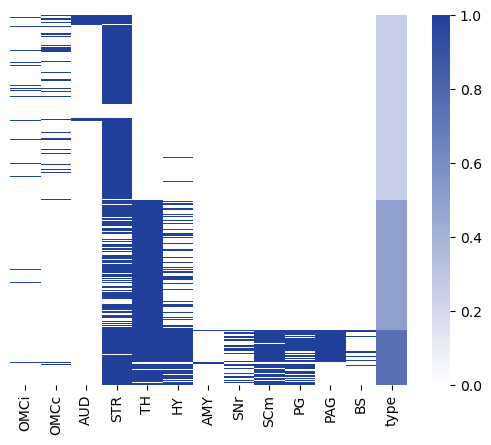

In [22]:
sns.heatmap(aca_mm[3], cmap=blue_cmp)
plt.gca().get_yaxis().set_visible(False)
# plt.savefig(out_path + "MM_N1_n6454_heatmap.jpeg", dpi=300, bbox_inches="tight")

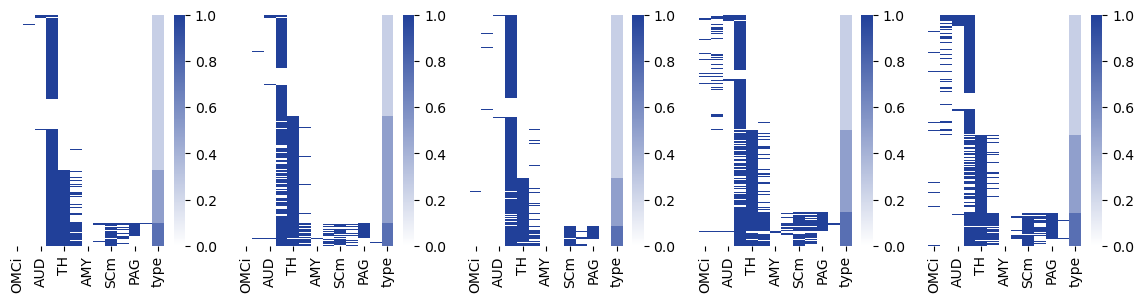

In [23]:
fig, axs = plt.subplots(1, len(aca_mm), figsize=(14.3,3))

i=0
for ax in axs.flat:
    sns.heatmap(aca_mm[i], cmap=blue_cmp, ax=ax)
    ax.get_yaxis().set_visible(False)
    i+=1
    
# fig.savefig(out_path+"aca_mm_N1_heatmaps.jpeg", dpi=300, bbox_inches="tight")

# summary plots
- node degree plots

(117113, 13)


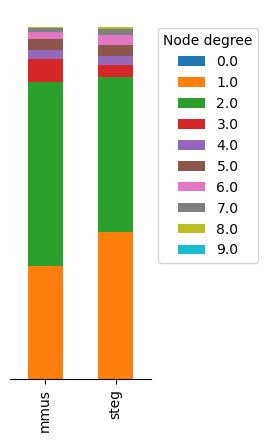

In [24]:
# calculate node degrees
print(aca_mm_all.shape)

aca_mm_int = aca_mm_all.drop(["ACAi", "type"], axis=1)
mm_nodes = aca_mm_int.sum(axis=1)
mm_node_counts = mm_nodes.value_counts().sort_index()
mm_node_proportion = mm_node_counts/mm_node_counts.sum()

aca_st_int = aca_st_all.drop(["ACAi", "type"], axis=1)
st_nodes = aca_st_int.sum(axis=1)
st_node_counts = st_nodes.value_counts().sort_index()
st_node_proportion = st_node_counts/st_node_counts.sum()

plot_df = pd.DataFrame(columns=['mmus', 'steg'])
# plot_df
plot_df['mmus'] = mm_node_proportion
plot_df['steg'] = st_node_proportion
plot_df.transpose().plot(kind='bar', stacked=True)
plt.gca().get_yaxis().set_visible(False)
plt.legend(bbox_to_anchor=(1.05, 0.95), loc='upper left', borderaxespad=0, title="Node degree")
plt.gca().set_aspect(5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
# plt.savefig(out_path+"mm_st_stack.jpeg", dpi=300)

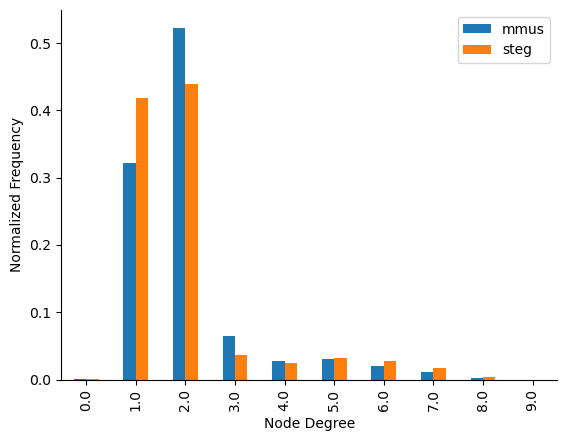

In [25]:
# plot_df['Node_Degree'] = plot_df.index
# plt.plot(plot_df.Node_Degree, plot_df.mmus, label="mmus", alpha=0.5)
# plt.plot(plot_df.Node_Degree, plot_df.steg, label="steg", alpha=0.5)
# plt.legend()

plot_df.plot(kind='bar')
plt.ylabel("Normalized Frequency")
plt.xlabel("Node Degree")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# plt.ylim((0,1))
# plt.savefig(out_path+"node_degree_hist.jpeg", dpi=300, bbox_inches='tight')

In [26]:
# calculate node degrees
print(aca_mm[3].shape)

aca_mm_int = aca_mm[3].drop(["ACAi", "type"], axis=1)
mm_nodes = aca_mm_int.sum(axis=1)
mm_node_counts = mm_nodes.value_counts().sort_index()
mm_node_proportion = mm_node_counts/mm_node_counts.sum()

aca_st_int = aca_st[5].drop(["ACAi", "type"], axis=1)
st_nodes = aca_st_int.sum(axis=1)
st_node_counts = st_nodes.value_counts().sort_index()
st_node_proportion = st_node_counts/st_node_counts.sum()

plot_df.plot(kind='bar')
plt.ylabel("Normalized Frequency")
plt.xlabel("Node Degree")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(labels=["mmus, N=1", "steg, N=1"])
# plt.ylim((0,1))
# plt.savefig(out_path+"node_degree_hist_N1.jpeg", dpi=300, bbox_inches='tight')

(7397, 13)


KeyError: "['ACAi'] not found in axis"

In [ ]:
# calculate node degrees
aca_mm_nodes = []
for i in range(len(aca_mm)):
    aca_mm_int = aca_mm[i].drop(["ACAi", "type"], axis=1)
    mm_nodes = aca_mm_int.sum(axis=1)
    mm_node_counts = mm_nodes.value_counts().sort_index()
    mm_node_proportion = mm_node_counts/mm_node_counts.sum()
    df_save = pd.DataFrame(mm_node_proportion, columns=["Normalized Frequency"]).reset_index(names="Node Degree")
    df_save["Species"] = "mmus"
    df_save["mouse"] = mice_mm[i]
    aca_mm_nodes.append(df_save)
    

aca_st_nodes = []
for i in range(len(aca_st)):
    aca_st_int = aca_st[i].drop(["ACAi", "type"], axis=1)
    st_nodes = aca_st_int.sum(axis=1)
    st_node_counts = st_nodes.value_counts().sort_index()
    st_node_proportion = st_node_counts/st_node_counts.sum()
    df_save = pd.DataFrame(st_node_proportion, columns=["Normalized Frequency"]).reset_index(names="Node Degree")
    df_save["Species"] = "steg"
    df_save["mouse"] = mice_st[i]
    aca_st_nodes.append(df_save)

mm_node_all = pd.concat(aca_mm_nodes)
st_node_all = pd.concat(aca_st_nodes)


In [ ]:
plot = pd.concat([mm_node_all, st_node_all])
sns.catplot(plot, x="Node Degree", y="Normalized Frequency", hue="Species", kind="bar")
# plt.savefig(out_path + "all_node_bar.jpeg", dpi=300, bbox_inches="tight")

In [ ]:
plot = pd.concat([mm_node_all, st_node_all])
sns.catplot(plot, x="Node Degree", y="Normalized Frequency", hue="Species")
# plt.savefig(out_path + "all_node_dots.jpeg", dpi=300, bbox_inches="tight")

# histograms

In [ ]:
aca_mm_int = aca_mm[3].drop(["ACAi", "type"], axis=1)
mm_sum = aca_mm_int.sum()
mm_proportion = mm_sum/aca_mm_int.shape[0]

aca_st_int = aca_st[5].drop(["ACAi", "type"], axis=1)
st_sum = aca_st_int.sum()
st_proportion = st_sum/aca_st_int.shape[0]

plot_df = pd.DataFrame(columns=['mmus', 'steg'])
# plot_df
plot_df['mmus'] = mm_proportion
plot_df['steg'] = st_proportion

plot_df.plot(kind='bar')
plt.ylabel("Neuron Proportion")
# plt.xlabel("Node Degree")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(labels=["mmus, N=1", "steg, N=1"])

# plt.savefig(out_path+"proj_hist_N1.jpeg", dpi=300, bbox_inches="tight")

In [ ]:
aca_mm_int = aca_mm_all.drop(["ACAi", "type"], axis=1)
mm_sum = aca_mm_int.sum()
mm_proportion = mm_sum/aca_mm_int.shape[0]

aca_st_int = aca_st_all.drop(["ACAi", "type"], axis=1)
st_sum = aca_st_int.sum()
st_proportion = st_sum/aca_st_int.shape[0]

plot_df = pd.DataFrame(columns=['mmus', 'steg'])
# plot_df
plot_df['mmus'] = mm_proportion
plot_df['steg'] = st_proportion


plot_df.plot(kind='bar')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.ylabel("Neuron Proportion")
# plt.savefig(out_path+'mm_st_hist.jpeg', dpi=300)

In [ ]:
mm_prop = []
for i in range(len(aca_mm)):
    df = aca_mm[i]
    df_int = df.drop(["ACAi", "type"], axis=1)
    df_sum = df_int.sum()
    df_prop = df_sum/df.shape[0]
    df_save = pd.DataFrame(df_prop, columns=["Neuron Proportion"]).reset_index(names="Area")
    df_save["Species"] = "mmus"
    df_save["mouse"] = mice_mm[i]
    mm_prop.append(df_save)

st_prop = []
for i in range(len(aca_st)):
    df = aca_st[i]
    df_int = df.drop(["ACAi", "type"], axis=1)
    df_sum = df_int.sum()
    df_prop = df_sum/df.shape[0]
    df_save = pd.DataFrame(df_prop, columns=["Neuron Proportion"]).reset_index(names="Area")
    df_save["Species"] = "steg"
    df_save["mouse"] = mice_st[i]
    st_prop.append(df_save)


mm_prop_all = pd.concat(mm_prop)
st_prop_all = pd.concat(st_prop)

In [ ]:
plot = pd.concat([mm_prop_all, st_prop_all])
sns.catplot(plot, x="Area", y="Neuron Proportion", hue="Species")
# plt.savefig(out_path + "all_hist_dots.jpeg", dpi=300, bbox_inches="tight")

In [ ]:
plot = pd.concat([mm_prop_all, st_prop_all])
sns.catplot(plot, x="Area", y="Neuron Proportion", hue="Species", kind="bar")
# plt.savefig(out_path + "all_hist_bar.jpeg", dpi=300, bbox_inches="tight")

In [ ]:
areas = aca_mm_int.columns

PAB_mm = np.zeros((len(areas),len(areas)))



for i in range(len(areas)):
    for j in range(len(areas)):
        areai = areas[i]
        areaj = areas[j]
        if aca_mm_int[areaj].sum() != 0: # create conditional so avoid divide by zero

            union = aca_mm_all[areai] + aca_mm_all[areaj]
            overlap = union == 2
            n_overlap = overlap.sum()
            total = aca_mm_all[areaj].sum()
            PAB_mm[i,j] = n_overlap/total

sns.heatmap(PAB_mm, yticklabels=areas, xticklabels=areas, cbar_kws={'label': 'P(B|A)'})
plt.title('Mmus')
plt.ylabel("B")
plt.xlabel("A")
# plt.savefig(out_path + "mm_all_pab.jpeg", dpi=300)

In [ ]:
areas = aca_st_int.columns

PAB_st = np.zeros((len(areas),len(areas)))



for i in range(len(areas)):
    for j in range(len(areas)):
        areai = areas[i]
        areaj = areas[j]
        if aca_st_int[areaj].sum() != 0: # create conditional so avoid divide by zero

            union = aca_st_all[areai] + aca_st_all[areaj]
            overlap = union == 2
            n_overlap = overlap.sum()
            total = aca_st_all[areaj].sum()
            PAB_st[i,j] = n_overlap/total

sns.heatmap(PAB_st, yticklabels=areas, xticklabels=areas, cbar_kws={'label': 'P(B|A)'})
plt.ylabel("B")
plt.xlabel("A")
plt.title('Steg')
# plt.savefig(out_path + "st_all_pab.jpeg", dpi=300)

# seperate by cell type

- aca_mm = [ ]
- aca_st = [ ]
- aca_pt_mm = [ ]
- aca_pt_st = [ ]
- aca_it_mm = [ ]
- aca_it_st = [ ]

# Dot Plots

In [50]:
it_aca_proportions = []

# ACA proportions
for i in range(num_samples):
    total = aca_it[i].shape[0]
    prop = aca_it[i].sum()/total
    it_aca_proportions.append(prop)


In [49]:
# dot plots for individual areas
areas = aca_it[0].columns

all_it_aca_proportions = []
for area in areas:
    area_proportion = metadata[["mice", "species", "dataset"]]
    area_prop = []
    for i in range(num_samples):
        area_prop.append(it_aca_proportions[i][area])

    area_proportion['proportion'] = area_prop
    
    all_it_aca_proportions.append(area_proportion)

NameError: name 'it_aca_proportions' is not defined

In [ ]:
areasi = pd.Series(data=list(range(len(areas))), index=areas)
# areasi

In [ ]:
# AUD
i = areasi["AUD"]
# plt.figure(figsize=(7,7))
df = all_it_aca_proportions[i]
# sns.catplot(data=df, x="species", y="proportion", hue="species", kind='point', 
#             errorbar=('ci',95), estimator=np.mean, n_boot=300)
sns.catplot(data=df, x="species", y="proportion", hue="species", size=10)
plt.title("IT - " + areas[i], size=20)
plt.ylim((0))
#     ax.set_ylim(-0.1,1.1)
# for j in range(df.shape[0]):
#     if df.species[j]=="Mmus":
#         k=0
#     else:
#         k=1
#     plt.text(x=k,y=df.proportion[j]+0.001,s=df.mice[j], 
#           fontdict=dict(color='black', size=12))
# plt.savefig(out_path+"it_aud_dotplot.jpeg", dpi=300, bbox_inches='tight')

In [27]:
# ACAc
i = areasi["ACAc"]
df = all_it_aca_proportions[i]
sns.catplot(data=df, x="species", y="proportion", hue="species", size=10)
plt.title("IT - " + areas[i], size=20)
plt.ylim((0))

# plt.savefig(out_path+"it_omcc_dotplot.jpeg", dpi=300, bbox_inches='tight')

NameError: name 'areasi' is not defined

In [28]:
# STR
i = areasi["STR"]
df = all_it_aca_proportions[i]
sns.catplot(data=df, x="species", y="proportion", hue="species", size=10)
plt.title("IT - " + areas[i], size=20)
plt.ylim((0))

# plt.savefig(out_path+"it_STR_dotplot.jpeg", dpi=300, bbox_inches='tight')

NameError: name 'areasi' is not defined

In [29]:
pt_aca_proportions = []

# ACA proportions
for i in range(num_samples):
    total = aca_pt[i].shape[0]
    prop = aca_pt[i].sum()/total
    pt_aca_proportions.append(prop)


# dot plots for individual areas
areas = aca_pt[0].columns

all_pt_aca_proportions = []
for area in areas:
    area_proportion = metadata[["mice", "species", "dataset"]]
    area_prop = []
    for i in range(num_samples):
        area_prop.append(pt_aca_proportions[i][area])

    area_proportion['proportion'] = area_prop
    
    all_pt_aca_proportions.append(area_proportion)

In [30]:
# PAG
i = areasi["PAG"]
df = all_pt_aca_proportions[i]
sns.catplot(data=df, x="species", y="proportion", hue="species", size=10)
plt.title("PT - " + areas[i], size=20)
plt.ylim((0))

# plt.savefig(out_path+"pt_PAG_dotplot.jpeg", dpi=300, bbox_inches='tight')

NameError: name 'areasi' is not defined

In [31]:
# SNr
i = areasi["SNr"]
df = all_pt_aca_proportions[i]
sns.catplot(data=df, x="species", y="proportion", hue="species", size=10)
plt.title("PT - " + areas[i], size=20)
plt.ylim((0))

# plt.savefig(out_path+"pt_SNr_dotplot.jpeg", dpi=300, bbox_inches='tight')

NameError: name 'areasi' is not defined

# histograms

In [32]:
# combine it/pt into one df
aca_mm_it_all = pd.concat(aca_it_mm)
aca_mm_pt_all = pd.concat(aca_pt_mm)
aca_st_it_all = pd.concat(aca_it_st)
aca_st_pt_all = pd.concat(aca_pt_st)


In [33]:
# create histograms by sampling 100 neurons

###### functions
def est_proj_prob(bin_proj, reps=1000, sample_size=300):
    """
    funtion takes subsample of projection matrix and repetitions as input.
    Funtion outputs vector where dim0 = projection probability of subsample, and dim1 = repetition
    """
    
    est_probs = []
    for i in range(reps):
        new = bin_proj.sample(sample_size)
        est_probs.append(new.sum()/sample_size)
        
#         if i%100 == 0:
#             print('finished simulation', i)
        
    return np.array(est_probs)

In [34]:
sim_reps = 1000
sim_sample_size=300

In [35]:
# create distribution by randomly sampling data
mm_it_probs = est_proj_prob(aca_mm_it_all, reps=sim_reps, sample_size=sim_sample_size)
    
# calculate fraction of projections in singing mice
st_it_probs = est_proj_prob(aca_st_it_all, reps=sim_reps, sample_size=sim_sample_size)

mm_it_probs = pd.DataFrame(mm_it_probs, columns=aca_mm_it_all.columns)
st_it_probs = pd.DataFrame(st_it_probs, columns=aca_st_it_all.columns)


(0.0, 0.084)

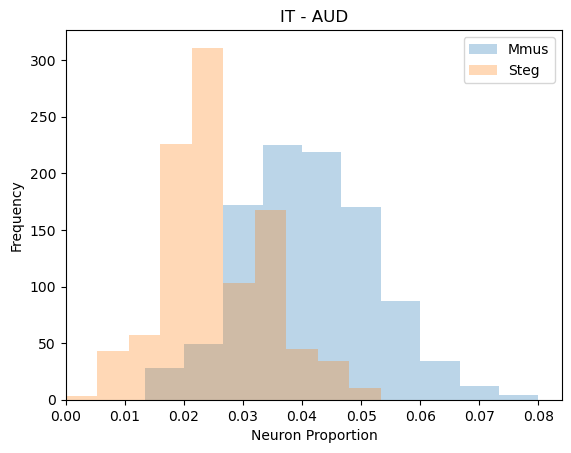

In [36]:
# AUD
areas = mm_it_probs.columns
areasi = pd.Series(data=list(range(len(areas))), index=areas)
i = areasi["AUD"]
plt.hist(mm_it_probs[areas[i]], alpha=0.3, label="Mmus")
plt.hist(st_it_probs[areas[i]], alpha=0.3, label="Steg")
plt.legend()
plt.title("IT - " + areas[i])
plt.xlabel("Neuron Proportion")
plt.ylabel("Frequency")
plt.xlim((0))
# plt.savefig(out_path+"aca_it_AUD_hist.jpeg", dpi=300)


(0.0, 0.9196666666666666)

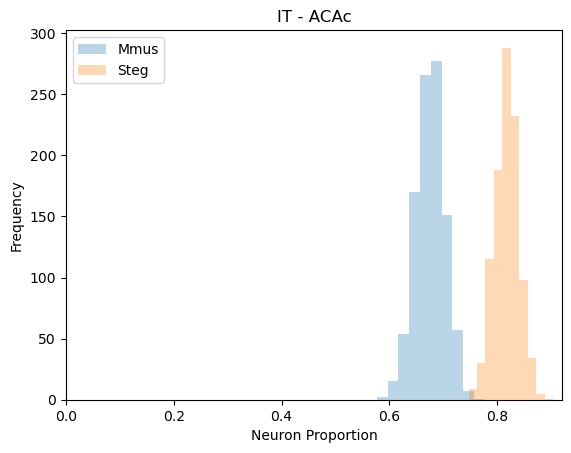

In [37]:
# ACAc
areas = mm_it_probs.columns
areasi = pd.Series(data=list(range(len(areas))), index=areas)
i = areasi["ACAc"]
plt.hist(mm_it_probs[areas[i]], alpha=0.3, label="Mmus")
plt.hist(st_it_probs[areas[i]], alpha=0.3, label="Steg")
plt.legend()
plt.title("IT - " + areas[i])
plt.xlabel("Neuron Proportion")
plt.ylabel("Frequency")
plt.xlim((0))

# plt.savefig(out_path+"aca_it_ACAc_hist.jpeg", dpi=300)


(0.0, 0.9521666666666667)

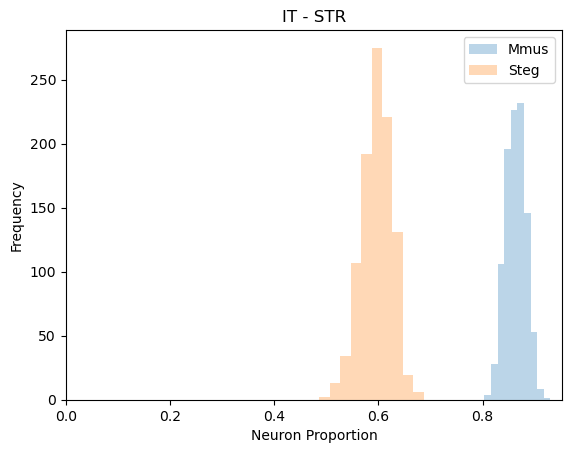

In [38]:
# STR
areas = mm_it_probs.columns
areasi = pd.Series(data=list(range(len(areas))), index=areas)
i = areasi["STR"]
plt.hist(mm_it_probs[areas[i]], alpha=0.3, label="Mmus")
plt.hist(st_it_probs[areas[i]], alpha=0.3, label="Steg")
plt.legend()
plt.title("IT - " + areas[i])
plt.xlabel("Neuron Proportion")
plt.ylabel("Frequency")
plt.xlim((0))

# plt.savefig(out_path+"aca_it_STR_hist.jpeg", dpi=300)


In [39]:
# create distribution by randomly sampling data
mm_pt_probs = est_proj_prob(aca_mm_pt_all, reps=sim_reps, sample_size=sim_sample_size)
    
# calculate fraction of projections in singing mice
st_pt_probs = est_proj_prob(aca_st_pt_all, reps=sim_reps, sample_size=sim_sample_size)

mm_pt_probs = pd.DataFrame(mm_pt_probs, columns=aca_mm_pt_all.columns)
st_pt_probs = pd.DataFrame(st_pt_probs, columns=aca_st_pt_all.columns)


(0.0, 0.8699999999999999)

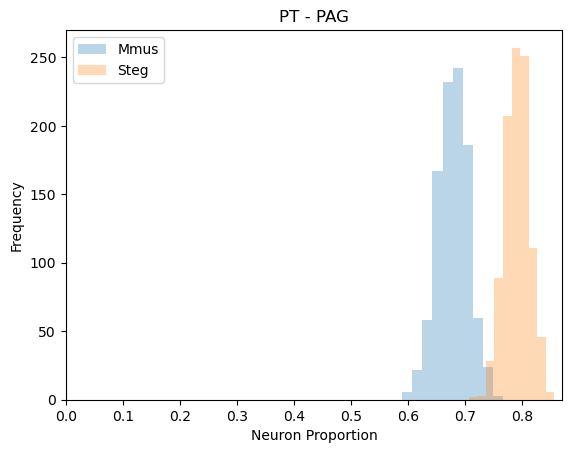

In [40]:
# PAG
areas = mm_pt_probs.columns
areasi = pd.Series(data=list(range(len(areas))), index=areas)
i = areasi["PAG"]
plt.hist(mm_pt_probs[areas[i]], alpha=0.3, label="Mmus")
plt.hist(st_pt_probs[areas[i]], alpha=0.3, label="Steg")
plt.legend()
plt.title("PT - " + areas[i])
plt.xlabel("Neuron Proportion")
plt.ylabel("Frequency")
plt.xlim((0))

# plt.savefig(out_path+"aca_pt_PAG_hist.jpeg", dpi=300)


(0.0, 0.5796666666666666)

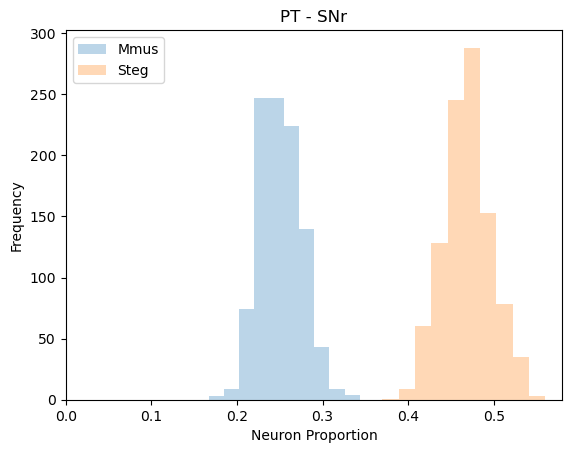

In [41]:
# SNr
areas = mm_pt_probs.columns
areasi = pd.Series(data=list(range(len(areas))), index=areas)
i = areasi["SNr"]
plt.hist(mm_pt_probs[areas[i]], alpha=0.3, label="Mmus")
plt.hist(st_pt_probs[areas[i]], alpha=0.3, label="Steg")
plt.legend()
plt.title("PT - " + areas[i])
plt.xlabel("Neuron Proportion")
plt.ylabel("Frequency")
plt.xlim((0))

# plt.savefig(out_path+"aca_pt_SNr_hist.jpeg", dpi=300)


# Volcano plot

In [42]:
# calculate means
mm_it_means = mm_it_probs.mean()
st_it_means = st_it_probs.mean()

p_vals = []
for i in range(len(areas)):
    roi = areas[i]
    if st_it_means[roi] > mm_it_means[roi]: # if st mean>mm mean, look for values greater
        above = st_it_probs[roi] > mm_it_means[roi]
        n_above= sum(above)
        p_vals.append(1 - n_above/sim_reps)
    elif st_it_means[roi] < mm_it_means[roi]: #else if st mean < mm mean, look for values lesser
        below = st_it_probs[roi] < mm_it_means[roi]
        n_below = sum(below)
        p_vals.append(1 - n_below/sim_reps)
    elif st_it_means[roi] == mm_it_means[roi]:
        above = st_it_probs[roi] > mm_it_means[roi]
        n_above= sum(above)
        p_vals.append(1 - n_above/sim_reps)
    elif st_it_means[roi]==mm_it_means[roi] and st_it_means[roi] == 0:
        p_vals.append(1)
    



In [43]:
plot_it = pd.DataFrame({"area":areas})
plot_it["p-value"] = p_vals
plot_it["mm_mean"] = mm_it_means.values
plot_it["st_mean"] = st_it_means.values
plot_it["effect_size"] = (plot_it["st_mean"]-plot_it["mm_mean"]) / (plot_it["st_mean"] + plot_it["mm_mean"])
plot_it["nlog10_p"] = -np.log10(plot_it["p-value"]+0.0001)
plot_it

,area,p-value,mm_mean,st_mean,effect_size,nlog10_p
0,OB,0.109,0.000613,0.006993,0.838738,0.962175
1,OMCi,0.144,0.013790,0.009117,-0.204016,0.841336
2,ACAi,1.000,1.000000,1.000000,0.000000,-0.000043
3,OMCc,0.000,0.068647,0.116690,0.259222,4.000000
4,ACAc,0.000,0.674627,0.817377,0.095677,4.000000
5,AUD,0.089,0.039550,0.025917,-0.208248,1.050122
6,STR,0.000,0.862723,0.594993,-0.183664,4.000000
7,TH,1.000,0.000000,0.000000,NaN,-0.000043
8,HY,0.265,0.009057,0.012800,0.171267,0.576590
9,AMY,1.000,0.000000,0.000000,NaN,-0.000043


In [44]:
# drop irrelevant rows
non_it = ["OB", "OMCi", "ACAi", "OMCc", "TH", "AMY", "HIP", "SNr", "SCm", "PG", "PAG", "RN"]
idx = plot_it["area"].isin(non_it)
plot_it = plot_it[~idx].reset_index(drop=True)
plot_it

,area,p-value,mm_mean,st_mean,effect_size,nlog10_p
0,ACAc,0.000,0.674627,0.817377,0.095677,4.000000
1,AUD,0.089,0.039550,0.025917,-0.208248,1.050122
2,STR,0.000,0.862723,0.594993,-0.183664,4.000000
3,HY,0.265,0.009057,0.012800,0.171267,0.576590


AttributeError: PathCollection.set() got an unexpected keyword argument 'size'

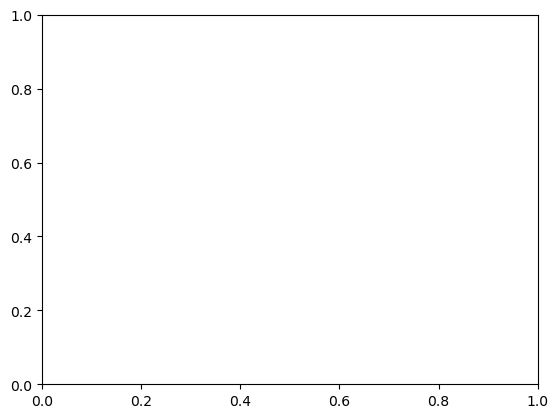

In [45]:

df = plot_it

x=df.effect_size
y=df.nlog10_p

plt.scatter(x,y, size=10)
plt.xlim([-1,1])
# plt.ylim([-0.1,4])
plt.axline((0, 0), (0, 1),linestyle='--', linewidth=0.5)
plt.axline((0, 0), (1, 0),linestyle='--', linewidth=0.5)
plt.axline((0, -np.log10(0.05)), (1,  -np.log10(0.05)),linestyle='--', color='r', alpha=0.75)
plt.text(-0.9, -np.log10(0.05)+.015, 'p<0.05', color='r', alpha=0.75)
plt.axline((0, -np.log10(0.01)), (1,  -np.log10(0.01)),linestyle='--', color='r', alpha=0.5)
plt.text(-0.9, -np.log10(0.01)+.015, 'p<0.01', color='r', alpha=0.75)


for i in range(df.shape[0]):
    plt.text(x=df.effect_size[i]+0.01,y=df.nlog10_p[i]+0.01,s=df.area[i], 
          fontdict=dict(color='black',size=10))


plt.title("ACA - IT")
plt.xlabel('Modulation Index')
plt.ylabel('-log10(p-value)')
# plt.savefig(out_f+'proj_prob_volcano.jpg',dpi=300, bbox_inches='tight')
# plt.savefig(out_f+'proj_prob_volcano.svg',dpi=300, bbox_inches='tight')

In [ ]:
# calculate means
mm_pt_means = mm_pt_probs.mean()
st_pt_means = st_pt_probs.mean()

p_vals = []
for i in range(len(areas)):
    roi = areas[i]
    if st_pt_means[roi] > mm_pt_means[roi]: # if st mean>mm mean, look for values greater
        above = st_pt_probs[roi] > mm_pt_means[roi]
        n_above= sum(above)
        p_vals.append(1 - n_above/sim_reps)
    elif st_pt_means[roi] < mm_pt_means[roi]: #else if st mean < mm mean, look for values lesser
        below = st_pt_probs[roi] < mm_pt_means[roi]
        n_below = sum(below)
        p_vals.append(1 - n_below/sim_reps)
    elif st_pt_means[roi] == mm_pt_means[roi]:
        above = st_pt_probs[roi] > mm_pt_means[roi]
        n_above= sum(above)
        p_vals.append(1 - n_above/sim_reps)
    elif st_pt_means[roi]==mm_pt_means[roi] and st_pt_means[roi] == 0:
        p_vals.append(1)
    



plot_pt = pd.DataFrame({"area":areas})
plot_pt["p-value"] = p_vals
plot_pt["mm_mean"] = mm_pt_means.values
plot_pt["st_mean"] = st_pt_means.values
plot_pt["effect_size"] = (plot_pt["st_mean"]-plot_pt["mm_mean"]) / (plot_pt["st_mean"] + plot_pt["mm_mean"])
plot_pt["nlog10_p"] = -np.log10(plot_pt["p-value"]+0.0001)
plot_pt

In [ ]:
# drop irrelevant rows
non_pt = ["OB", "OMCi", "ACAi", "OMCc", "HIP"]
idx = plot_pt["area"].isin(non_pt)
plot_pt = plot_pt[~idx].reset_index(drop=True)


In [ ]:
df = plot_pt

x=df.effect_size
y=df.nlog10_p

plt.scatter(x,y)
plt.xlim([-1,1])
# plt.ylim([-0.1,4])
plt.axline((0, 0), (0, 1),linestyle='--', linewidth=0.5)
plt.axline((0, 0), (1, 0),linestyle='--', linewidth=0.5)
plt.axline((0, -np.log10(0.05)), (1,  -np.log10(0.05)),linestyle='--', color='r', alpha=0.75)
plt.text(-0.9, -np.log10(0.05)+.015, 'p<0.05', color='r', alpha=0.75)
plt.axline((0, -np.log10(0.01)), (1,  -np.log10(0.01)),linestyle='--', color='r', alpha=0.5)
plt.text(-0.9, -np.log10(0.01)+.015, 'p<0.01', color='r', alpha=0.75)


for i in range(df.shape[0]):
    plt.text(x=df.effect_size[i]+0.01,y=df.nlog10_p[i]+0.01,s=df.area[i], 
          fontdict=dict(color='black',size=10))


plt.title("ACA - PT")
plt.xlabel('Modulation Index')
plt.ylabel('-log10(p-value)')
# plt.savefig(out_f+'proj_prob_volcano.jpg',dpi=300, bbox_inches='tight')
# plt.savefig(out_f+'proj_prob_volcano.svg',dpi=300, bbox_inches='tight')

# try with t-test

In [46]:
mmus_it_prop = []
steg_it_prop = []
for i in range(len(all_it_aca_proportions)):
    df = all_it_aca_proportions[i]
    mm = df[df["species"]=="Mmus"]
    mmus_it_prop.append(mm["proportion"])
    st = df[df["species"]=="Steg"]
    steg_it_prop.append(st["proportion"])
mmus_it_array = np.array(mmus_it_prop)
steg_it_array = np.array(steg_it_prop)

pd.set_option('display.max_rows', None)
results = stats.ttest_ind(mmus_it_array, steg_it_array, axis=1)
p_vals = results[1]
plot = pd.DataFrame({"area":areas, "p-value":p_vals})

plot["mm_mean"] = mmus_it_array.mean(axis=1)
plot["st_mean"] = steg_it_array.mean(axis=1)
plot["effect_size"] = (plot["st_mean"]-plot["mm_mean"]) / (plot["st_mean"] + plot["mm_mean"])
plot["nlog10_p"] = -np.log10(plot["p-value"])

# drop irrelevant rows
non_it = ["OB", "OMCi", "ACAi", "ACAc", "TH", "AMY", "HIP", "SNr", "SCm", "PG", "PAG", "RN"]
idx = plot["area"].isin(non_it)
plot = plot[~idx].reset_index(drop=True)


plot



NameError: name 'all_it_aca_proportions' is not defined

In [47]:

df = plot

x=df.effect_size
y=df.nlog10_p

plt.scatter(x,y, s=25)
plt.xlim([-1,1])
# plt.ylim([-0.1,4])
plt.axline((0, 0), (0, 1),linestyle='--', linewidth=0.5)
plt.axline((0, 0), (1, 0),linestyle='--', linewidth=0.5)
plt.axline((0, -np.log10(0.05)), (1,  -np.log10(0.05)),linestyle='--', color='r', alpha=0.75, linewidth=0.5)
plt.text(-0.9, -np.log10(0.05)+.015, 'p<0.05', color='r', alpha=0.75)
plt.axline((0, -np.log10(0.01)), (1,  -np.log10(0.01)),linestyle='--', color='r', alpha=0.5, linewidth=0.5)
plt.text(-0.9, -np.log10(0.01)+.015, 'p<0.01', color='r', alpha=0.75)


for i in range(df.shape[0]):
    plt.text(x=df.effect_size[i]+0.01,y=df.nlog10_p[i]+0.01,s=df.area[i], 
          fontdict=dict(color='black',size=10))


plt.title("ACA - IT")
plt.xlabel('Modulation Index')
plt.ylabel('-log10(p-value)')
# plt.savefig(out_path+'aca_it_volcano.jpg',dpi=300, bbox_inches='tight')
# plt.savefig(out_path+'aca_it_volcano.svg',dpi=300, bbox_inches='tight')

AttributeError: 'DataFrame' object has no attribute 'effect_size'

/var/folders/l2/gvq0gkm95b1fbrlls4tsq2wr0000gp/T/ipykernel_14229/547530992.py:13: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  results = stats.ttest_ind(mmus_pt_array, steg_pt_array, axis=1)


Text(0, 0.5, '-log10(p-value)')

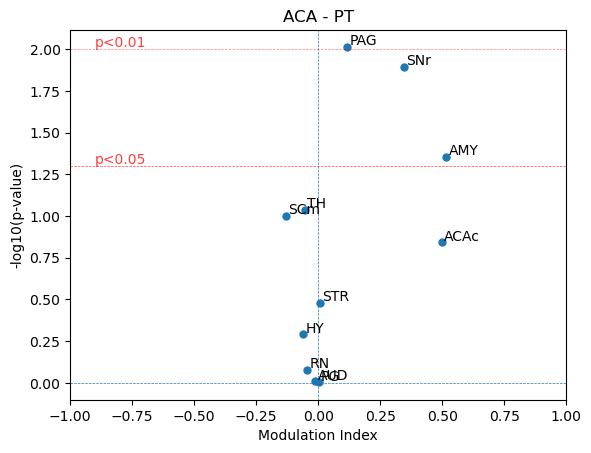

In [48]:
mmus_pt_prop = []
steg_pt_prop = []
for i in range(len(all_pt_aca_proportions)):
    df = all_pt_aca_proportions[i]
    mm = df[df["species"]=="Mmus"]
    mmus_pt_prop.append(mm["proportion"])
    st = df[df["species"]=="Steg"]
    steg_pt_prop.append(st["proportion"])
mmus_pt_array = np.array(mmus_pt_prop)
steg_pt_array = np.array(steg_pt_prop)

pd.set_option('display.max_rows', None)
results = stats.ttest_ind(mmus_pt_array, steg_pt_array, axis=1)
p_vals = results[1]
plot = pd.DataFrame({"area":areas, "p-value":p_vals})

plot["mm_mean"] = mmus_pt_array.mean(axis=1)
plot["st_mean"] = steg_pt_array.mean(axis=1)
plot["effect_size"] = (plot["st_mean"]-plot["mm_mean"]) / (plot["st_mean"] + plot["mm_mean"])
plot["nlog10_p"] = -np.log10(plot["p-value"])

# drop irrelevant rows
non_pt = ["OB", "OMCi", "ACAi", "OMCc", "HIP"]
idx = plot["area"].isin(non_pt)
plot = plot[~idx].reset_index(drop=True)






df = plot

x=df.effect_size
y=df.nlog10_p

plt.scatter(x,y, s=25)
plt.xlim([-1,1])
# plt.ylim([-0.1,4])
plt.axline((0, 0), (0, 1),linestyle='--', linewidth=0.5)
plt.axline((0, 0), (1, 0),linestyle='--', linewidth=0.5)
plt.axline((0, -np.log10(0.05)), (1,  -np.log10(0.05)),linestyle='--', color='r', alpha=0.75, linewidth=0.5)
plt.text(-0.9, -np.log10(0.05)+.015, 'p<0.05', color='r', alpha=0.75)
plt.axline((0, -np.log10(0.01)), (1,  -np.log10(0.01)),linestyle='--', color='r', alpha=0.5, linewidth=0.5)
plt.text(-0.9, -np.log10(0.01)+.015, 'p<0.01', color='r', alpha=0.75)


for i in range(df.shape[0]):
    plt.text(x=df.effect_size[i]+0.01,y=df.nlog10_p[i]+0.01,s=df.area[i], 
          fontdict=dict(color='black',size=10))


plt.title("ACA - PT")
plt.xlabel('Modulation Index')
plt.ylabel('-log10(p-value)')
# plt.savefig(out_path+'aca_pt_volcano.jpg',dpi=300, bbox_inches='tight')
# plt.savefig(out_path+'aca_pt_volcano.svg',dpi=300, bbox_inches='tight')
